# Lux data sampling

**Goal**: sample of Lux data to test `spellux` lemmatization

**Logic**:
- ...

## imports

In [175]:
from impresso_commons.utils.s3 import get_s3_client, alternative_read_text, IMPRESSO_STORAGEOPT
from impresso_commons.utils.s3 import fixed_s3fs_glob
from impresso_commons.utils.kube import (
    make_scheduler_configuration,
    make_worker_configuration,
)
from dask_k8 import DaskCluster
from dask import bag as db
from dask.distributed import Client
import json
import os
import codecs

## setup dask k8 cluster

In [176]:
# dask_client = Client()
# dask_client.scheduler_info()['services']['dashboard']

In [102]:
image_uri = "ic-registry.epfl.ch/dhlab/impresso_data-sanity-check:v1"
memory = "10G"
# memory = "1G"
n_workers = 100

In [103]:
print(make_worker_configuration(
        docker_image=image_uri,
        memory=memory
    ))


      containers:
        - image: ic-registry.epfl.ch/dhlab/impresso_data-sanity-check:v1
          args: [dask-worker, $(DASK_SCHEDULER_ADDRESS), --nthreads, '1', --no-bokeh, --memory-limit, 10G, --death-timeout, '120']
          imagePullPolicy: Always
          name: dask-worker
          env:
            - name: POD_IP
              valueFrom:
                fieldRef:
                  fieldPath: status.podIP
            - name: POD_NAME
              valueFrom:
                fieldRef:
                  fieldPath: metadata.name
            - name: EXTRA_PIP_PACKAGES
              value: 
            - name: EXTRA_CONDA_PACKAGES
              value:
            - name: SE_ACCESS_KEY
              value: 18c8f162ee474359ba3a6dbf08edca0f
            - name: SE_SECRET_KEY
              value: 733f24dbbef045b480da0fdd088a92b6
          resources:
            requests:
              cpu: 1
              memory: 10G
            limits:
              cpu: 1
              memory: 10G
 

In [177]:
worker_config = """
      containers:
        - image: ic-registry.epfl.ch/dhlab/impresso_data-sanity-check:v1
          args: [dask-worker, $(DASK_SCHEDULER_ADDRESS), --nthreads, '1', --no-bokeh, --memory-limit, 10G, --death-timeout, '120']
          imagePullPolicy: Always
          name: dask-worker
          env:
            - name: POD_IP
              valueFrom:
                fieldRef:
                  fieldPath: status.podIP
            - name: POD_NAME
              valueFrom:
                fieldRef:
                  fieldPath: metadata.name
            - name: EXTRA_PIP_PACKAGES
              value: 
            - name: EXTRA_CONDA_PACKAGES
              value:
            - name: SE_ACCESS_KEY
              value: 18c8f162ee474359ba3a6dbf08edca0f
            - name: SE_SECRET_KEY
              value: 733f24dbbef045b480da0fdd088a92b6
          resources:
            requests:
              cpu: 1
              memory: 10G
            limits:
              cpu: 1
              memory: 10G
          volumeMounts:
            - mountPath: /scratch
              name: scratch
              subPath: romanell
      volumes:
        - name: scratch
          persistentVolumeClaim:
            claimName: dhlab-scratch
"""

In [178]:
cluster = DaskCluster(
    namespace="dhlab",
    cluster_id="impresso-load",
    scheduler_pod_spec=make_scheduler_configuration(),
    worker_pod_spec=worker_config
)
cluster.create()
cluster.scale(n_workers, blocking=False)
dask_client = cluster.make_dask_client()

Scheduler: tcp://10.90.50.17:30316
Dashboard: http://10.90.50.17:10012


In [179]:
dask_client

Client Scheduler: tcp://10.90.50.17:30316 Dashboard: http://10.90.50.17:8787/status,Cluster Workers: 100 Cores: 100 Memory: 1000.00 GB


## configuration

In [68]:
S3_LANGID_BUCKET = "s3://processed-canonical-data/langident/v01"
S3_OCRQA_BUCKET = "s3://processed-canonical-data/ocrqa/ocrqa004/"
S3_CANONICAL_DATA_BUCKET = "s3://original-canonical-fixed"
S3_REBUILT_DATA_BUCKET = "s3://canonical-rebuilt-release"
S3_STATS_BUCKET = "s3://impresso-stats/content-item-stats/"
S3_LINGPROCESSED_BUCKET = "s3://processed-canonical-data/linguistic-processing/2020-03-11/"

## read language identification data

In [10]:
def list_newspapers(bucket_name=S3_CANONICAL_DATA_BUCKET, s3_client=get_s3_client()):
    """List newspapers contained in an s3 bucket with impresso data."""
    print(f'Fetching list of newspapers from {bucket_name}')

    if "s3://" in bucket_name:
        bucket_name = bucket_name.replace("s3://", "") #.split("/")[0]

    paginator = s3_client.get_paginator('list_objects')

    newspapers = set()
    for n, resp in enumerate(paginator.paginate(Bucket=bucket_name, PaginationConfig={'PageSize': 10000})):
        # means the bucket is empty
        if 'Contents' not in resp:
            continue

        for f in resp['Contents']:
            newspapers.add(f["Key"].split("/")[0])
    print(f'{bucket_name} contains {len(newspapers)} newspapers')
    return newspapers

In [11]:
nps = list_newspapers(S3_REBUILT_DATA_BUCKET)

Fetching list of newspapers from s3://canonical-rebuilt-release
canonical-rebuilt-release contains 76 newspapers


In [12]:
len(nps)

76

In [13]:
lang_ident_files = [
    f"{os.path.join(S3_LANGID_BUCKET, np, '*.bz2')}"
    for np in nps
]

In [14]:
lang_df = db.read_text(
    lang_ident_files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads)\
.to_dataframe()[['cid', 'lg', 'tp', 'orig_lg']].set_index('cid')\
.repartition(partition_size="100MB").persist()

In [15]:
lang_df.npartitions

118

In [16]:
lang_df[lang_df.lg=='fr'].shape[0].compute()

35900085

In [37]:
lang_df[lang_df.lg=='de'].shape[0].compute()

8266928

In [35]:
lang_df[lang_df.lg=='lb'].shape[0].compute()

42086

In [21]:
lux_df = lang_df[lang_df.lg=='lb'].compute()

In [22]:
lux_df['year'] =  lux_df.index.map(lambda cid: int(cid.split('-')[1]))

In [23]:
lux_df['np-year'] =  lux_df.index.map(lambda cid: f"{cid.split('-')[0]}-{cid.split('-')[1]}")

In [24]:
lux_df.head()

,lg,tp,orig_lg,year,np-year
cid,,,,,
actionfem-1929-01-15-a-i0009,lb,ar,lb,1929,actionfem-1929
actionfem-1929-01-15-a-i0010,lb,ar,lb,1929,actionfem-1929
actionfem-1929-02-15-a-i0009,lb,ar,lb,1929,actionfem-1929
actionfem-1929-03-15-a-i0003,lb,ar,lb,1929,actionfem-1929
actionfem-1929-05-15-a-i0005,lb,ar,lb,1929,actionfem-1929


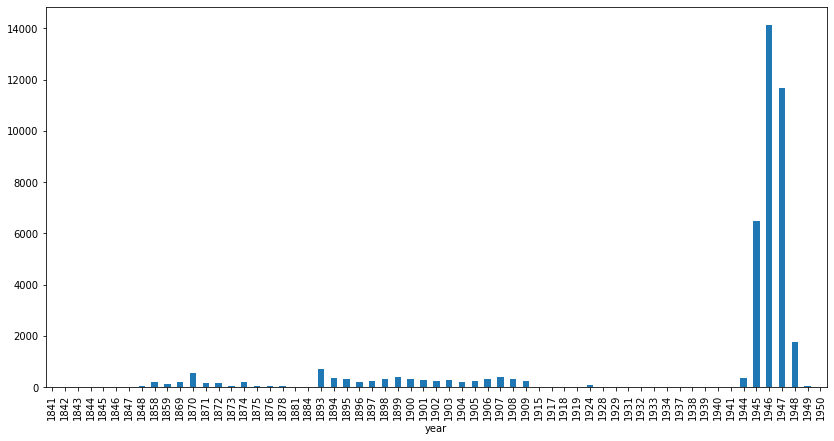

In [25]:
%matplotlib inline
lux_df.groupby(by='year').size().plot(kind='bar', figsize=(14, 7))

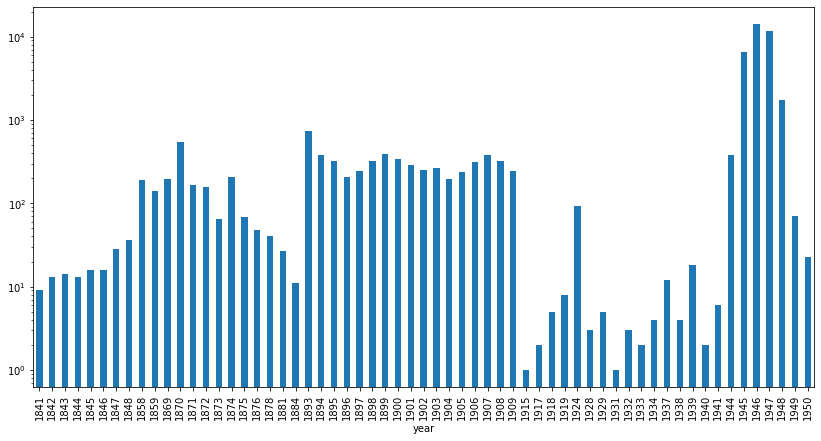

In [26]:
%matplotlib inline
lux_df.groupby(by='year').size().plot(kind='bar', figsize=(14, 7), logy=True)

take home message:
- Lux language is present over ~110 years within our corpus
- but for half of the years (n = 32, out of 61), there are 100 or less Lux articles (per year)

## read content item stats

In [29]:
from dask import dataframe as ddf

ci_stats_df = ddf.read_csv(
    f"{os.path.join(S3_STATS_BUCKET, '*')}",
    storage_options=IMPRESSO_STORAGEOPT
).fillna(0).astype(
    {
        'title_length':'int64',
        'n_tokens': 'int64',
        'year': 'int64',
        'newspaper': 'str',
        'type': 'str'
    }
).set_index('id').persist()

In [30]:
ci_stats_df.head()

,year,newspaper,type,n_tokens,title_length
id,,,,,
BDC-1839-01-20-a-i0001,1839,BDC,ar,250,4
BDC-1839-01-20-a-i0002,1839,BDC,ar,758,0
BDC-1839-01-20-a-i0003,1839,BDC,ar,14,31
BDC-1839-01-20-a-i0004,1839,BDC,ar,349,22
BDC-1839-01-20-a-i0005,1839,BDC,ar,193,0


In [32]:
lux_df.head()

,lg,tp,orig_lg,year,np-year
cid,,,,,
actionfem-1929-01-15-a-i0009,lb,ar,lb,1929,actionfem-1929
actionfem-1929-01-15-a-i0010,lb,ar,lb,1929,actionfem-1929
actionfem-1929-02-15-a-i0009,lb,ar,lb,1929,actionfem-1929
actionfem-1929-03-15-a-i0003,lb,ar,lb,1929,actionfem-1929
actionfem-1929-05-15-a-i0005,lb,ar,lb,1929,actionfem-1929


In [38]:
# the join between a Dask Dataframe and a pandas one
# does not quite work. thus conversion before join is necessary
lux_ddf = ddf.from_pandas(lux_df, npartitions=100)

In [42]:
lux_df = lux_ddf.join(ci_stats_df[['n_tokens']], how='inner').compute()

In [44]:
lux_df.head()

,lg,tp,orig_lg,year,np-year,n_tokens
actionfem-1929-01-15-a-i0009,lb,ar,lb,1929,actionfem-1929,2
actionfem-1929-01-15-a-i0010,lb,ar,lb,1929,actionfem-1929,7
actionfem-1929-02-15-a-i0009,lb,ar,lb,1929,actionfem-1929,2
actionfem-1929-03-15-a-i0003,lb,ar,lb,1929,actionfem-1929,5
actionfem-1929-05-15-a-i0005,lb,ar,lb,1929,actionfem-1929,124


## read OCR QA data

- read ocr qa data only for newspaper-years for which we have some articles in Lux
- join together `lux_df` and ocr qa information
- look at distribution of values
- select a random sample by decade (size = 2 ?) and get the content item ids

In [45]:
lb_nps = set([
    x.split('-')[0]
    for x in list(lux_df['np-year'].unique())
])

In [46]:
len(lb_nps)

13

In [48]:
ocrqa_files = [
    f"{os.path.join(S3_OCRQA_BUCKET, f'{np}_ocrqa.jsonl.bz2')}"
    for np in lb_nps
]

In [49]:
ocrqa_lux_ddf = db.read_text(
    ocrqa_files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads)\
.to_dataframe().set_index('ci_ref')\
.repartition(partition_size="100MB").persist()

In [50]:
ocrqa_lux_ddf.shape[0].compute()

1895508

In [51]:
ocrqa_lux_ddf.index.nunique().compute()

1895508

In [52]:
ocrqa_lux_ddf.head()

,ocrqa
ci_ref,
actionfem-1927-10-15-a-i0001,0.91
actionfem-1927-10-15-a-i0002,0.81
actionfem-1927-10-15-a-i0003,0.73
actionfem-1927-10-15-a-i0004,0.79
actionfem-1927-10-15-a-i0005,0.82


In [53]:
ocrqa_lux_df = ocrqa_lux_ddf.compute()

In [54]:
ocrqa_lux_df.head()

,ocrqa
ci_ref,
actionfem-1927-10-15-a-i0001,0.91
actionfem-1927-10-15-a-i0002,0.81
actionfem-1927-10-15-a-i0003,0.73
actionfem-1927-10-15-a-i0004,0.79
actionfem-1927-10-15-a-i0005,0.82


In [55]:
df = lux_df.join(ocrqa_lux_df, how='inner')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42060 entries, actionfem-1929-01-15-a-i0009 to volkfreu1869-1876-12-24-a-i0002
Data columns (total 7 columns):
lg          42060 non-null object
tp          42060 non-null object
orig_lg     36800 non-null object
year        42060 non-null int64
np-year     42060 non-null object
n_tokens    42060 non-null int64
ocrqa       42060 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.6+ MB


In [57]:
df.head()

,lg,tp,orig_lg,year,np-year,n_tokens,ocrqa
actionfem-1929-01-15-a-i0009,lb,ar,lb,1929,actionfem-1929,2,0.00
actionfem-1929-01-15-a-i0010,lb,ar,lb,1929,actionfem-1929,7,0.86
actionfem-1929-02-15-a-i0009,lb,ar,lb,1929,actionfem-1929,2,0.50
actionfem-1929-03-15-a-i0003,lb,ar,lb,1929,actionfem-1929,5,0.67
actionfem-1929-05-15-a-i0005,lb,ar,lb,1929,actionfem-1929,124,0.90


In [58]:
df.n_tokens.describe()

count    42060.000000
mean       188.446600
std        256.304459
min          1.000000
25%         42.000000
50%         93.000000
75%        226.000000
max       3622.000000
Name: n_tokens, dtype: float64

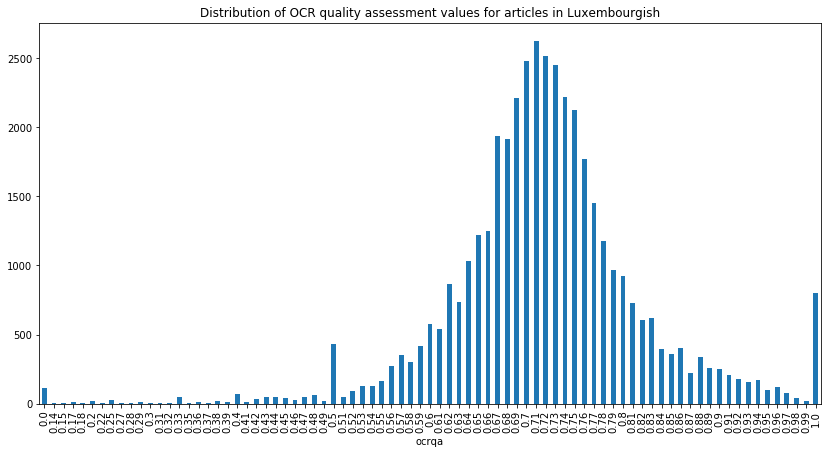

In [142]:
df.groupby('ocrqa').size().plot(
        kind='bar',
    figsize=(14, 7),
    title='Distribution of OCR quality assessment values for articles in Luxembourgish',
)

## sampling

In [60]:
sample_df = df[
    (df.ocrqa >= 0.7 ) & (df.tp=='ar') & (df.n_tokens >= 90)
].groupby('year').apply(lambda x: x.sample())

In [64]:
sample_df.head()

,,lg,tp,orig_lg,year,np-year,n_tokens,ocrqa
year,,,,,,,,
1841,diekwochen-1841-11-06-a-i0018,lb,ar,lb,1841,diekwochen-1841,143,0.77
1842,diekwochen-1842-04-09-a-i0010,lb,ar,lb,1842,diekwochen-1842,262,0.72
1843,diekwochen-1843-08-19-a-i0011,lb,ar,lb,1843,diekwochen-1843,91,0.70
1844,diekwochen-1844-02-03-a-i0005,lb,ar,lb,1844,diekwochen-1844,104,0.71
1845,diekwochen-1845-12-06-a-i0009,lb,ar,lb,1845,diekwochen-1845,161,0.75


In [66]:
type(sample_df)

pandas.core.frame.DataFrame

## read spacy-tokenized data

- read all from newspapers/years in the final sample
- keep only the content items in the actual sample
- for each item, pass the list of tokens to spellux for lemmatization

In [81]:
input_files = []

In [82]:
for np_year in list(sample_df['np-year'].unique()):
    np, year = np_year.split('-')
    filename = f"{np_year}.ling.annotation.jsonl.bz2"
    input_files.append(f"{os.path.join(S3_LINGPROCESSED_BUCKET, filename)}")

In [84]:
input_files[:5]

['s3://processed-canonical-data/linguistic-processing/2020-03-11/diekwochen-1841.ling.annotation.jsonl.bz2',
 's3://processed-canonical-data/linguistic-processing/2020-03-11/diekwochen-1842.ling.annotation.jsonl.bz2',
 's3://processed-canonical-data/linguistic-processing/2020-03-11/diekwochen-1843.ling.annotation.jsonl.bz2',
 's3://processed-canonical-data/linguistic-processing/2020-03-11/diekwochen-1844.ling.annotation.jsonl.bz2',
 's3://processed-canonical-data/linguistic-processing/2020-03-11/diekwochen-1845.ling.annotation.jsonl.bz2']

In [97]:
sampled_ci_ids = sample_df.index.get_level_values(1).to_list()

In [98]:
len(sampled_ci_ids)

53

In [99]:
sampled_ci_ids[:10]

['diekwochen-1841-11-06-a-i0018',
 'diekwochen-1842-04-09-a-i0010',
 'diekwochen-1843-08-19-a-i0011',
 'diekwochen-1844-02-03-a-i0005',
 'diekwochen-1845-12-06-a-i0009',
 'diekwochen-1846-12-26-a-i0013',
 'diekwochen-1847-12-25-a-i0010',
 'diekwochen-1848-11-22-a-i0006',
 'luxzeit1858-1858-10-01-a-i0006',
 'luxzeit1858-1859-01-23-a-i0001']

In [108]:
ci_bag = db.read_text(
    input_files, storage_options=IMPRESSO_STORAGEOPT
).map(json.loads)

In [116]:
sampled_content_items = ci_bag.filter(lambda i: i['id'] in sampled_ci_ids).compute()

In [117]:
len(sampled_content_items)

53

In [133]:
doc_tokens = [
    token['t']
    for sentence in sampled_content_items[0]['sents']
    for token in sentence['tok']
]

In [128]:
doc_pos = [
    token['p']
    for sentence in sampled_content_items[0]['sents']
    for token in sentence['tok']
]

In [129]:
doc_spacy_lemmas = [
    token['l']
    for sentence in sampled_content_items[0]['sents']
    for token in sentence['tok']
]

In [135]:
# sampled_content_items[0]

## export data for `spellux` processing

- export metadata for sampled articles (including link to impresso interface)
- export JSON (spacy-like) for each content item
- export .txt for each article

In [152]:
import json

In [142]:
!mkdir -p /home/romanell/Documents/impresso/lux-lemmatization-sample/text

In [138]:
export_dir = "/home/romanell/Documents/impresso/lux-lemmatization-sample"

In [167]:
for ci in sampled_content_items:
    export_path = os.path.join(
        export_dir,
        "text",
        f"{ci['id']}.json"
    )
    with open(export_path, mode='w', encoding='utf-8') as ofile:
        json.dump(ci, ofile)

In [172]:
ll -H {export_dir}/text

total 1216
-rw-r--r-- 1 romanell   9336 Apr 21 10:09 actionfem-1929-05-15-a-i0005.json
-rw-r--r-- 1 romanell   9034 Apr 21 10:09 actionfem-1932-04-15-a-i0017.json
-rw-r--r-- 1 romanell  73590 Apr 21 10:09 actionfem-1934-04-15-a-i0010.json
-rw-r--r-- 1 romanell   7309 Apr 21 10:09 deletz1893-1893-02-19-a-i0004.json
-rw-r--r-- 1 romanell  90331 Apr 21 10:09 deletz1893-1894-02-24-a-i0001.json
-rw-r--r-- 1 romanell 125735 Apr 21 10:09 deletz1893-1895-12-14-a-i0001.json
-rw-r--r-- 1 romanell  15549 Apr 21 10:09 deletz1893-1896-07-25-a-i0002.json
-rw-r--r-- 1 romanell  19070 Apr 21 10:09 deletz1893-1897-04-17-a-i0008.json
-rw-r--r-- 1 romanell   9774 Apr 21 10:09 deletz1893-1898-04-16-a-i0007.json
-rw-r--r-- 1 romanell  19207 Apr 21 10:09 deletz1893-1899-04-29-a-i0001.json
-rw-r--r-- 1 romanell  24654 Apr 21 10:09 deletz1893-1900-11-17-a-i0007.json
-rw-r--r-- 1 romanell  27857 Apr 21 10:09 deletz1893-1901-02-02-a-i0001.json
-rw-r--r-- 1 romanell   7494 Apr 21 10:09 deletz1893-1902-11-08-a-i0

In [164]:
sample_df.to_pickle(os.path.join(export_dir, 'metadata_df.pkl'))

## release resources

In [180]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    y

concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - E

concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-pac